In [2]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum

import datetime

from pyspark.sql import Window
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import re
from pyspark.sql import functions as sF
from pyspark.sql import types as sT

from functools import reduce

In [3]:
spark = SparkSession\
        .builder\
        .appName("Sparkify")\
        .getOrCreate()

In [4]:
#loading data
data_path = 'mini_sparkify_event_data.json'
user_log = spark.read.json(data_path)


In [5]:
# See the frame schema
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
#converting to pandas
user_log_pandas= user_log.toPandas()
user_log_pandas.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [7]:
user_log_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 18 columns):
artist           228108 non-null object
auth             286500 non-null object
firstName        278154 non-null object
gender           278154 non-null object
itemInSession    286500 non-null int64
lastName         278154 non-null object
length           228108 non-null float64
level            286500 non-null object
location         278154 non-null object
method           286500 non-null object
page             286500 non-null object
registration     278154 non-null float64
sessionId        286500 non-null int64
song             228108 non-null object
status           286500 non-null int64
ts               286500 non-null int64
userAgent        278154 non-null object
userId           286500 non-null object
dtypes: float64(2), int64(4), object(12)
memory usage: 39.3+ MB


In [8]:
user_log_pandas.isnull().sum()

artist           58392
auth                 0
firstName         8346
gender            8346
itemInSession        0
lastName          8346
length           58392
level                0
location          8346
method               0
page                 0
registration      8346
sessionId            0
song             58392
status               0
ts                   0
userAgent         8346
userId               0
dtype: int64

In [9]:
#here artist,reg,useragent etc has same 8346 null value.lets analysis futher these colums
user_log.createOrReplaceTempView('data');

In [10]:
spark.sql('''
            select artist,userId,page
            from data
            where artist IS NULL

''')

#we can obsever that there are some empty string

spark.sql('''
            select userId,artist,page
            from data
            where userId == ""


''').show()
user_log_pandas[user_log_pandas['userId']==""].count()



+------+------+-----+
|userId|artist| page|
+------+------+-----+
|      |  null| Home|
|      |  null| Help|
|      |  null| Home|
|      |  null|Login|
|      |  null| Home|
|      |  null|Login|
|      |  null|Login|
|      |  null|Login|
|      |  null| Home|
|      |  null|Login|
|      |  null| Home|
|      |  null| Home|
|      |  null|Login|
|      |  null| Home|
|      |  null|About|
|      |  null| Home|
|      |  null| Home|
|      |  null|Login|
|      |  null| Home|
|      |  null| Home|
+------+------+-----+
only showing top 20 rows



artist              0
auth             8346
firstName           0
gender              0
itemInSession    8346
lastName            0
length              0
level            8346
location            0
method           8346
page             8346
registration        0
sessionId        8346
song                0
status           8346
ts               8346
userAgent           0
userId           8346
dtype: int64

In [11]:
#As we can see user how user not logged in or about to login in has artist and other columns null
#As these user will not churn we can say so that we can remove them from the dataset
user_log_pandas=user_log_pandas[user_log_pandas['userId'] != ""]
user_log=user_log.filter(user_log.userId != "")

In [12]:
user_log_pandas.isnull().sum()

artist           50046
auth                 0
firstName            0
gender               0
itemInSession        0
lastName             0
length           50046
level                0
location             0
method               0
page                 0
registration         0
sessionId            0
song             50046
status               0
ts                   0
userAgent            0
userId               0
dtype: int64

In [13]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [14]:
#let start with Exploratory Analysis
len(user_log_pandas.userId.unique())

225

In [15]:
len(user_log_pandas.page.unique())

19

In [16]:
len(user_log_pandas.artist.unique())

17656

In [17]:
len(user_log_pandas.gender.unique())

2

In [18]:
len(user_log_pandas.sessionId.unique())

2312

In [19]:
#we have total  225 users,19 pages,2 gender(male,female),2312 unique session to analysis

In [20]:
# Churn is a label for user who cancelled
# Define a flag function
flag= udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
user_log = user_log.withColumn("churn", flag("page"))

In [22]:
window_churn = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

In [23]:
user_log = user_log.withColumn("churn", Fsum("churn").over(window_churn))

In [24]:
user_log_pandas=user_log.toPandas()

In [26]:
user_log_pandas.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
0,Sleeping With Sirens,Logged In,Darianna,F,0,Carpenter,202.97098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Captain Tyin Knots VS Mr Walkway (No Way),200,1539003534000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
1,Francesca Battistelli,Logged In,Darianna,F,1,Carpenter,196.54485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Beautiful_ Beautiful (Album),200,1539003736000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
2,Brutha,Logged In,Darianna,F,2,Carpenter,263.13098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,She's Gone,200,1539003932000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
3,None,Logged In,Darianna,F,3,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",PUT,Thumbs Up,1538016340000,31,None,307,1539003933000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
4,Josh Ritter,Logged In,Darianna,F,4,Carpenter,316.23791,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Folk Bloodbath,200,1539004195000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0


In [28]:
user_log.createOrReplaceTempView('new_data');

In [42]:

user_log_pandas.drop_duplicates(subset='userId').groupby(['churn'])['userId'].count()

churn
0    173
1     52
Name: userId, dtype: int64

In [45]:
#frequency function
def plot_frequency(subset, group, labels, x_title="Number of users", y_title="Subscription status"):
    ax = user_log_pandas.drop_duplicates(subset=subset).groupby(
                                group)['userId'].count().plot(
                                kind='barh', figsize=(8,5), 
                                title='Number of unique users per category');
    ax.set_xlabel(x_title);
    ax.set_yticklabels(labels, rotation=0)
    ax.set_ylabel(y_title);


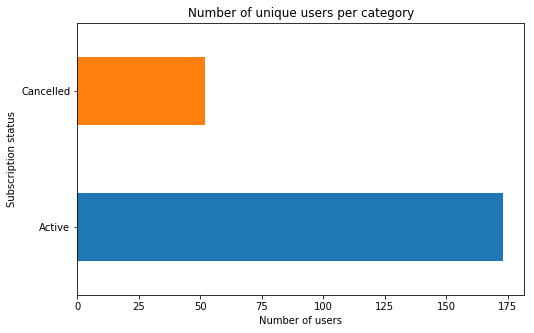

In [46]:
plot_frequency(['userId'], ['churn'], ['Active', 'Cancelled'])

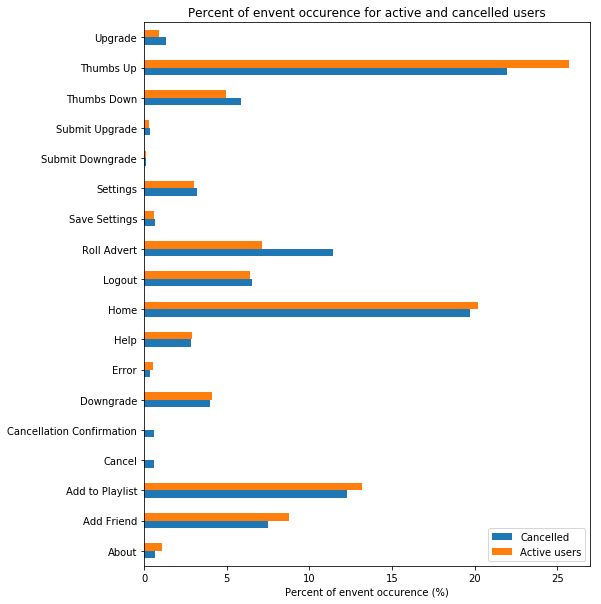

In [47]:
users_1 = user_log_pandas[user_log_pandas.churn == 1].groupby(['page'])['userId'].count().drop('NextSong')
users_1 = users_1 /users_1.sum()*100

users_0 = user_log_pandas[user_log_pandas.churn == 0].groupby(['page'])['userId'].count().drop('NextSong')
users_0 = users_0 /users_0.sum()*100

users_df = pd.DataFrame({'Cancelled': users_1,'Active users':users_0})
ax = users_df.plot(kind='barh', figsize=(8,10));
ax.set_xlabel('Percent of envent occurence (%)')
ax.set_title('Percent of envent occurence for active and cancelled users');

In [49]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month)
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%w'))

In [53]:
funcs = {'hour':get_hour, 'day':get_day, 'month':get_month, 'week_day':get_weekday}
for label, func in funcs.items():
    user_log = user_log.withColumn(label, func(user_log.ts))
    

In [54]:
user_log_pandas = user_log.toPandas()
user_log_pandas.sample(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,song,status,ts,userAgent,userId,churn,hour,day,month,week_day
107676,None,Logged In,Azrael,M,389,Hicks,NaN,paid,"Atlanta-Sandy Springs-Roswell, GA",PUT,...,None,307,1541091467000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",89,0,16,1,11,4
130057,Dwight Yoakam,Logged In,Michael,M,28,Miller,239.30730,paid,"Phoenix-Mesa-Scottsdale, AZ",PUT,...,You're The One,200,1542129431000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.8; r...,60,0,17,13,11,2
258530,John Mayer,Logged In,Michael,M,71,Williams,359.23546,paid,"Syracuse, NY",PUT,...,Friends_ Lovers Or Nothing,200,1541965358000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,14,0,19,11,11,0
56533,Metric,Logged In,Emma,F,27,Lee,247.69261,paid,"Winston-Salem, NC",PUT,...,Wet Blanket,200,1542099653000,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",16,0,9,13,11,2
267033,Eminem,Logged In,Ashlynn,F,46,Williams,173.24363,paid,"Tallahassee, FL",PUT,...,Any Man,200,1542930233000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",74,0,23,22,11,4


In [55]:
def get_series(col, churn, normalize=False):
    ''' 
    Get a series either of churn users or existing users
    THe function can normalize the series and return a percent value
    col: {str} the column to plot (hour, month, day, week_day)
    churn: {int} 0 or 1
    normalize: {bool} T/F, Default is False
    return a sorted pandas series
    '''
    ser1 = user_log_pandas[user_log_pandas.churn == churn].groupby([col])['userId'].count()
    try:
        ser1.index = ser1.index.astype(int)
    except:
        pass
    if normalize:
        ser1=ser1/ser1.sum()*100
    return ser1.sort_index()

In [56]:
def draw_time(col, normalize=True, figsize=(16,4), title=None, label_rotation=0):
    '''
    Draw a bar plot for churn and existing users based on 
         a specific column (hour, month, day, week_day)
         
    normalize: {bool} T/F, Default is True
    figsize: {tuple} the plot size, default is (16,4)
    title: descriptive title part
    Returns: None
    '''
    df_time = pd.DataFrame({'Cancelled': get_series(col, 1, normalize),
                            'Active users':get_series(col, 0, normalize)})
    ax = df_time.plot(kind='bar', figsize=figsize);
    ax.set_ylabel('Percent of users')
    if title is None:
        title = col
    ax.set_ylabel(f'Percent of users')
    #print(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=label_rotation)
    ax.set_title(f'Percent of users took action per {title}') 
    return ax

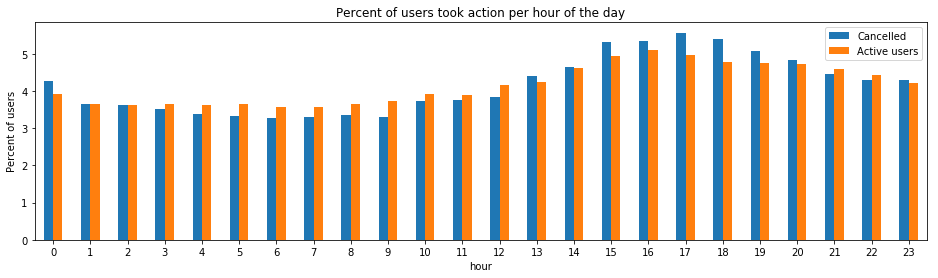

In [57]:
draw_time('hour', title='hour of the day');
#It appears that no visual effect of difference between remaining and cancelling users according to hour of the day. 
#The only effect is that the cancelled users are more active on the time between 13:00 to 20:00

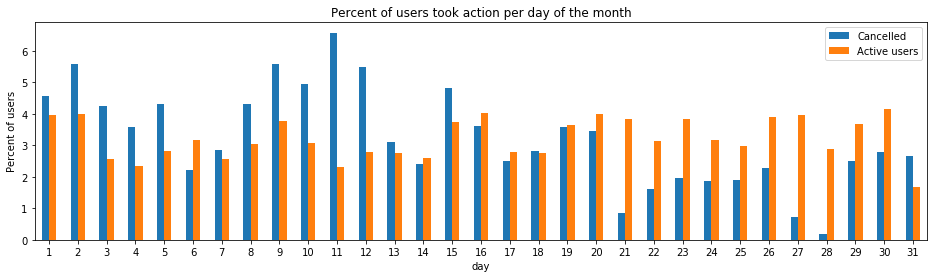

In [58]:
draw_time('day', title='day of the month');
#Most cancellation happens at the end of the month, which is logical to avoid renewal fees

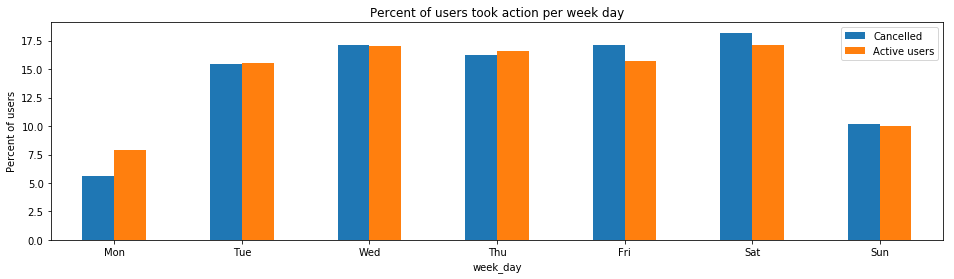

In [59]:
ax = draw_time('week_day', title='week day')
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0);
#It is noticable that on Friday and Saturday, the churn users are more active, while the remaining users are more active Monday. 
#The remaining days have no noticable difference between user's types.

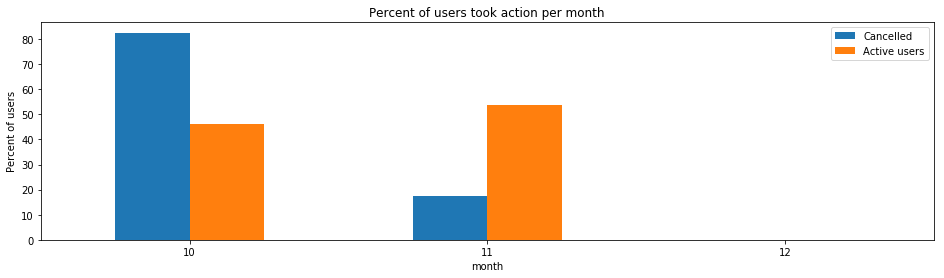

In [60]:
draw_time('month');

In [96]:
#Feature engineering
churn_users = user_log.select('userId', 'churn').dropDuplicates()

# check
churn_users.show(10)

+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
+------+-----+
only showing top 10 rows



In [62]:
def create_dummy_df (col, dictionary):
    '''
    Create a dataframe to map a variable
    col: the column name
    dictionary: the mapping of from->to numeric values
    return a dataframe of 2 columns
    '''
    # To map M and F to numeric values, we first should map to string numbers (to avoid spark error)
    col_df = user_log.select('userId', col).dropDuplicates().replace(dictionary, subset=col)
    # Then convert the result to numeric value
    col_df = col_df.select('userId', col_df[col].cast('int'))
    # Check
    print(col_df.printSchema(), col_df.show(3))
    return col_df

In [63]:
gender_df = create_dummy_df('gender', {'M':'1', 'F':'0'})

root
 |-- userId: string (nullable = true)
 |-- gender: integer (nullable = true)

+------+------+
|userId|gender|
+------+------+
|    44|     0|
|    46|     0|
|    41|     0|
+------+------+
only showing top 3 rows

None None


In [66]:
level_df = create_dummy_df('level', {'paid':'1', 'free':'0'})

root
 |-- userId: string (nullable = true)
 |-- level: integer (nullable = true)

+------+-----+
|userId|level|
+------+-----+
|100021|    0|
|200021|    0|
|200001|    0|
+------+-----+
only showing top 3 rows

None None


In [67]:
user_log_pandas.artist.unique().shape[0]

17656

In [70]:
song_length = user_log.filter(user_log.page=='NextSong').select('userId', 'sessionId', 'length')
song_length = song_length.withColumn('hours', (song_length.length / 3600))
song_length = song_length.groupBy('userId', 'sessionId').sum('hours')
song_length = song_length.groupBy('userId').agg(
                        sF.avg('sum(hours)').alias('mean_hours'), 
                        sF.stddev('sum(hours)').alias('stdev_hours')).na.fill(0)
song_length.toPandas().head(10)

,userId,mean_hours,stdev_hours
0,100010,2.656385,1.594089
1,200002,4.352263,3.481087
2,125,0.580309,0.000000
3,51,14.535440,11.600663
4,124,10.042779,9.370878
5,7,1.509289,1.737257
6,54,5.645595,6.724164
7,15,9.470389,6.159368
8,155,9.202745,6.528672
9,100014,3.134420,1.754365


In [71]:
# To get the Number of ThumbsUp, ThumbsDown, InviteFriends, downgrades, ...
# I think it is better to get all actions except Chorn actions (Cancel, cancelation confirmation)
# The to normalize them as percent to sum all to 100.

# The distribution of pages per user (FILLING NAN with 0)
user_page_distribution = user_log.groupby('userId').pivot('page').count().na.fill(0) #.toPandas().head(30)

# Drop Cancel	Cancellation Confirmation columns
user_page_distribution = user_page_distribution.drop(*['Cancel','Cancellation Confirmation'])

# Normalizing each row to sum to 1
# the columns to be summed
pages_cols = user_page_distribution.columns[1:]

# Add a total column
new_df = user_page_distribution.withColumn('total', sum(user_page_distribution[col] for col in pages_cols))

# Apply normalization per column
for col in pages_cols:
    new_df = new_df.withColumn(f'norm_{col}', new_df[col] / new_df['total'] * 100.)
    
# Remove the total column    
new_df = new_df.drop('total')

# Remove the original columns
new_df = new_df.drop(*pages_cols)

# Rename the normalized columns back
oldColumns = new_df.columns
newColumns = ['userId'] + pages_cols
user_page_distribution = reduce(lambda new_df, idx: new_df.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), new_df)

# Freeup memory
new_df=None

user_page_distribution.toPandas().head(10)

,userId,About,Add Friend,Add to Playlist,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,200002,0.632911,0.843882,1.687764,1.054852,0.000000,0.421941,4.219409,1.054852,81.645570,1.476793,0.000000,0.632911,0.000000,0.210970,1.265823,4.430380,0.421941
1,100010,0.262467,1.049869,1.837270,0.000000,0.000000,0.524934,2.887139,1.312336,72.178478,13.648294,0.000000,0.000000,0.000000,0.000000,1.312336,4.461942,0.524934
2,125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,88.888889,11.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,51,0.081235,1.137287,2.112104,0.934200,0.040617,0.487409,3.046304,0.974817,85.743298,0.000000,0.040617,0.487409,0.000000,0.000000,0.852965,4.061738,0.000000
4,124,0.145078,1.533679,2.445596,0.849741,0.124352,0.476684,3.647668,1.222798,84.538860,0.082902,0.124352,0.414508,0.000000,0.000000,0.849741,3.544041,0.000000
5,7,0.000000,0.497512,2.487562,0.000000,0.497512,0.497512,4.975124,1.492537,74.626866,7.960199,0.497512,1.492537,0.000000,0.000000,0.497512,3.482587,0.995025
6,54,0.145560,0.960699,2.096070,1.135371,0.029112,0.494905,3.755459,1.048035,82.707424,1.368268,0.087336,0.494905,0.029112,0.029112,0.844250,4.745269,0.029112
7,15,0.087796,1.360843,2.589991,1.229148,0.087796,0.351185,4.082529,1.185250,84.021071,0.043898,0.087796,0.702371,0.000000,0.000000,0.614574,3.555751,0.000000
8,155,0.199601,1.097804,2.395210,1.197605,0.299401,0.898204,2.994012,1.397206,81.836327,0.798403,0.000000,0.499002,0.000000,0.099800,0.299401,5.788423,0.199601
9,132,0.173611,1.779514,1.649306,0.824653,0.130208,0.694444,3.602431,1.475694,83.680556,0.086806,0.173611,0.737847,0.000000,0.043403,0.737847,4.166667,0.043403


In [73]:
# number of changing songs
song_user_df = user_log.filter(user_log.page == 'NextSong').groupBy(
                        'userId', 'sessionId').count()
song_user_df = song_user_df.groupBy('userId').agg(
                        sF.avg('count').alias('mean_songs'), 
                        sF.stddev('count').alias('stdev_songs'))
song_user_df = song_user_df.na.fill(0)
song_user_df.show(3)

+------+------------------+------------------+
|userId|        mean_songs|       stdev_songs|
+------+------------------+------------------+
|100010|39.285714285714285| 22.96166577663945|
|200002|              64.5|51.309843110264914|
|   125|               8.0|               0.0|
+------+------------------+------------------+
only showing top 3 rows



In [74]:
artists_user_fans = user_log.select('userId', 'artist').dropDuplicates().groupBy('userId').count().withColumnRenamed("count", "num_aritst")
artists_user_fans.show(3)

+------+----------+
|userId|num_aritst|
+------+----------+
|100010|       253|
|200002|       340|
|   125|         9|
+------+----------+
only showing top 3 rows



In [75]:
session_end = user_log.groupBy('userId', 'sessionId').max('ts').withColumnRenamed(
                                                            'max(ts)', 'end')
session_start = user_log.groupBy('userId', 'sessionId').min('ts').withColumnRenamed(
                                                            'min(ts)', 'start')
session_df = session_start.join(session_end,['userId', 'sessionId'])
ticks_per_hours = 1000 * 60 * 60
session_df = session_df.select('userId', 'sessionId', ((
    session_df.end-session_df.start)/ticks_per_hours).alias('session_hours'))
session_df.show(3)

+------+---------+------------------+
|userId|sessionId|     session_hours|
+------+---------+------------------+
|   101|      635|55.000277777777775|
|   110|     1776|1.3908333333333334|
|   120|      627|15.855555555555556|
+------+---------+------------------+
only showing top 3 rows



In [77]:
num_sessions_user_df = user_log.select('userId', 'sessionId').dropDuplicates().groupby('userId').count().withColumnRenamed('count', 'num_sessions')
num_sessions_user_df.show(3)

+------+------------+
|userId|num_sessions|
+------+------------+
|100010|           7|
|200002|           6|
|   125|           1|
+------+------------+
only showing top 3 rows



In [79]:
# 2-I The user's subscription age
def days_since_subscription(df, col_name='days_on'):
    # timestamp of users registration
    reg_ts = df.select('userId', 'registration').dropDuplicates().withColumnRenamed('registration', 'start')
    # reg_ts.show(5)
    # The maximum timestamp found for the user
    end_ts = df.groupBy('userId').max('ts').withColumnRenamed('max(ts)', 'end')
    # end_ts.show(5)
    # The difference
    reg_df = reg_ts.join(end_ts,'userId')
    ticks_per_day = 1000 * 60 * 60 * 24 # as the timestamp is in ticks (0.001 seconds)
    # Merge in one df
    reg_df = reg_df.select('userId', ((reg_df.end-reg_df.start)/ticks_per_day).alias(col_name))
    # reg_ts.join(user_max_ts, user_reg_ts.userId == user_max_ts.userId).select(user_reg_ts["userId"], ((user_max_ts["max(ts)"]-user_reg_ts["registration"])/(1000*60*60*24)).alias("regDay"))
    return reg_df

reg_df = days_since_subscription(user_log, col_name='days_total_subscription')
reg_df.show(5)

+------+-----------------------+
|userId|days_total_subscription|
+------+-----------------------+
|100010|      55.64365740740741|
|200002|      70.07462962962963|
|   125|      71.31688657407408|
|   124|     131.55591435185184|
|    51|     19.455844907407407|
+------+-----------------------+
only showing top 5 rows



In [81]:
df_paid = user_log.filter(user_log.level=='paid')
paid_df = days_since_subscription(df_paid, col_name='days_paid_subscription')
paid_df.show(5)

+------+----------------------+
|userId|days_paid_subscription|
+------+----------------------+
|200002|     70.07462962962963|
|   124|    131.55591435185184|
|    51|    19.455844907407407|
|    15|    56.513576388888886|
|    54|    110.75168981481481|
+------+----------------------+
only showing top 5 rows



In [82]:
df_free = user_log.filter(user_log.level=='free')
free_df = days_since_subscription(df_free, col_name='days_free_subscription')
free_df.show(5)

+------+----------------------+
|userId|days_free_subscription|
+------+----------------------+
|100010|     55.64365740740741|
|200002|     41.49415509259259|
|   125|     71.31688657407408|
|     7|     72.77818287037037|
|    54|     96.45179398148149|
+------+----------------------+
only showing top 5 rows



In [84]:
paid_free_df = user_log.filter(user_log.page=='NextSong').groupBy('userId').pivot('level').count()
paid_free_df = paid_free_df.na.fill(0)
active_cols = paid_free_df.columns[1:]
paid_free_df = paid_free_df.withColumn('total', 
                                       sum(paid_free_df[col] for col in active_cols))
for col in active_cols:
    paid_free_df = paid_free_df.withColumn(f'{col}_percent', 
                                           paid_free_df[col] / paid_free_df.total * 100)
active_cols.append('total')    
paid_free_df = paid_free_df.drop(*active_cols)
paid_free_df.show(10)
paid_free_df = paid_free_df.drop('free_percent')

+------+------------------+-----------------+
|userId|      free_percent|     paid_percent|
+------+------------------+-----------------+
|200002| 22.48062015503876|77.51937984496125|
|100010|             100.0|              0.0|
|   125|             100.0|              0.0|
|     7|             100.0|              0.0|
|   124|               0.0|            100.0|
|    51|               0.0|            100.0|
|    54|15.452305526223162|84.54769447377683|
|    15|               0.0|            100.0|
|   155|12.317073170731707| 87.6829268292683|
|   132|1.4522821576763485|98.54771784232366|
+------+------------------+-----------------+
only showing top 10 rows



In [93]:
# the features to collect
user_features = [gender_df, paid_free_df, song_length, 
                   user_page_distribution, song_user_df, artists_user_fans, 
                    num_sessions_user_df, reg_df]
user_features_names = ['gender_df', 'paid_free_df', 'song_length', 
                   'user_page_distribution', 'song_user_df', 'artists_user_fans', 
                    'num_sessions_user_df', 'reg_df']

In [98]:
final_df = churn_users
def join_features(base, new):
    df_to_join = new
    base = base.join(df_to_join, 'userId', how='inner')
    return base.dropDuplicates()

for i, feature in enumerate(user_features):
    print(f'Preparing features of the {user_features_names[i]} dataframe', end='; ')
    final_df = join_features(final_df, feature)
    
    
final_df = final_df.orderBy('userId', ascending=True)

Preparing features of the gender_df dataframe; the new frame's dimensions is: 225 * 3
Preparing features of the paid_free_df dataframe; the new frame's dimensions is: 225 * 4
Preparing features of the song_length dataframe; the new frame's dimensions is: 225 * 6
Preparing features of the user_page_distribution dataframe; the new frame's dimensions is: 225 * 23
Preparing features of the song_user_df dataframe; the new frame's dimensions is: 225 * 25
Preparing features of the artists_user_fans dataframe; the new frame's dimensions is: 225 * 26
Preparing features of the num_sessions_user_df dataframe; the new frame's dimensions is: 225 * 27
Preparing features of the reg_df dataframe; the new frame's dimensions is: 225 * 28
*** ALL DONE ***


In [101]:
final_df.write.save('dataset.csv', format='csv', header=True)

In [106]:
user_log_pd = final_df.toPandas()
user_log_pd.head(10)

,userId,churn,gender,paid_percent,mean_hours,stdev_hours,About,Add Friend,Add to Playlist,Downgrade,...,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade,mean_songs,stdev_songs,num_aritst,num_sessions,days_total_subscription
0,10,0,1,100.000000,7.725295,8.985657,0.251572,1.509434,1.132075,0.880503,...,0.000000,0.000000,0.503145,4.654088,0.000000,112.166667,133.324291,566,6,51.762650
1,100,0,1,91.349739,5.497368,5.137933,0.373367,1.524580,1.897946,0.933416,...,0.031114,0.031114,0.840075,4.604854,0.031114,78.882353,74.057621,1706,35,64.873773
2,100001,1,0,0.000000,2.435677,1.055065,0.000000,1.081081,1.621622,0.000000,...,0.000000,0.000000,1.081081,4.324324,1.081081,33.250000,16.839933,126,4,44.800220
3,100002,0,0,100.000000,3.441661,5.918537,0.000000,0.458716,2.293578,0.917431,...,0.000000,0.000000,0.000000,2.293578,0.000000,48.750000,84.428964,185,4,160.472072
4,100003,1,0,0.000000,1.709225,2.265005,0.000000,0.000000,2.631579,0.000000,...,0.000000,0.000000,0.000000,3.947368,0.000000,25.500000,33.234019,51,2,22.748113
5,100004,0,0,48.301486,3.215005,3.808716,0.000000,1.526104,1.847390,0.803213,...,0.160643,0.240964,0.883534,2.811245,0.642570,47.100000,55.459706,734,21,172.440081
6,100005,1,1,0.000000,2.572022,0.907743,0.000000,1.401869,1.401869,0.000000,...,0.000000,0.000000,1.401869,3.271028,1.869159,38.500000,13.771952,150,5,85.195590
7,100006,1,0,0.000000,1.626359,0.000000,0.000000,9.523810,2.380952,0.000000,...,0.000000,0.000000,4.761905,4.761905,0.000000,26.000000,0.000000,27,1,9.127164
8,100007,1,0,100.000000,3.225164,3.782691,0.000000,3.281853,1.737452,1.351351,...,0.000000,0.000000,1.158301,3.667954,0.000000,47.000000,55.366958,358,9,115.387616
9,100008,0,0,93.393782,8.860963,12.599652,0.319149,1.808511,3.191489,1.063830,...,0.106383,0.000000,0.638298,3.936170,0.425532,128.666667,182.128160,624,6,68.228565


In [ ]:
#modeling

In [109]:
#Rename churn column into label
final_df = final_df.withColumn('label', final_df['churn'].cast('float')).drop('churn') #important to have float type

# Feature columns to be converted into vector
feature_cols = final_df.drop('label').drop('userId').columns

In [112]:
train, test = final_df.drop('userId').randomSplit([0.8, 0.2], seed=42)

In [113]:
#making pipeline

def buildCV(classifier, paramGrid):
    '''
    Build a cross validation pipeline
    
    INPUT
    classifier: untrained machine learning classifier
    paramGrid: a grid of parameters to search over
    
    OUTPUT
    crossval: cross validator
    '''
    # Configure an ML pipeline
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="rawFeatures")
    scaler = MaxAbsScaler(inputCol="rawFeatures", outputCol="scaledFeatures")
#     scaler = MinMaxScaler(inputCol="rawFeatures", outputCol="scaledFeatures")
#     scaler = StandardScaler(inputCol="rawFeatures", outputCol="scaledFeatures", withStd=True, withMean=True)
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    # Cross validation
    crossval = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=paramGrid,
        evaluator=MulticlassClassificationEvaluator(metricName='f1'),
        numFolds=3
    )
    return crossval

In [123]:
def trainModel(classifier, train, paramGrid):
    '''
    Train the machine learning model
    
    INPUT
    classifier: untrained machine learning classifier
    paramGrid: a grid of parameters to search over
    train (Spark dataframe): training dataset
    
    OUTPUT
    model: trained machine learning model
    training_time (float): training time
    '''
    crossval = buildCV(classifier, paramGrid)
    start = time()
    model = crossval.fit(train)
    end = time()
    training_time = end - start
    return model, training_time


def evaluateModel(model, data, prob=False):
    '''
    Evaluate model performance
    
    INPUT
    model: trained machine learning model
    data (Spark dataframe): either training set or testing set
    
    OUTPUT
    evalMetrics (dict): disctionary of evaluation metrics
    '''
    # Make prediction
    start = time()
    pred = model.transform(data)
    if prob:
        evaluator = MulticlassClassificationEvaluator(predictionCol="probability", labelCol="label")
    else:
        evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
    end = time()
    prediction_time = end - start
    
    # Calculate metrics
    evalMetrics = {}
    evalMetrics["precision"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedPrecision"})
    evalMetrics["recall"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedRecall"})
    evalMetrics["f1"] = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
    evalMetrics["accuracy"] = evaluator.evaluate(pred, {evaluator.metricName: "accuracy"})
    evalMetrics['confusion_matrix'] = pred.groupby("label").pivot("prediction").count()
    evalMetrics['prediction_time'] = prediction_time
    
    return evalMetrics
def trainAndEval(classifier, train, test, paramGrid):
    '''
    Train and evaluate model performance on both training and testing sets
    
    INPUT
    classifier: untrained machine learning classifier
    train: training set
    test: testing set
    paramGrid: a grid of parameters to search over
    
    OUTPUT
    evalMetrics (dict): disctionary of evaluation metrics, 
        compiled from training, testing metrics
    summary (Spark dataframe): table of evaluation metrics
    model: trained machine learning model
    '''
    # Train the model
    model, training_time = trainModel(classifier, train, paramGrid)
    
    # Evaluate model performance
    evalMetricsTraining = evaluateModel(model, train)
    evalMetricsTesting = evaluateModel(model, test)

    # Compile metrics
    evalMetrics = {}
    evalMetrics['train_time'] = training_time
    evalMetrics['f1_train'] = evalMetricsTraining['f1']
    evalMetrics['acc_train'] = evalMetricsTraining['accuracy']
    evalMetrics['f1_test'] = evalMetricsTesting['f1']
    evalMetrics['acc_test'] = evalMetricsTesting['accuracy']
    evalMetrics['pred_time'] = evalMetricsTraining['prediction_time'] \
        + evalMetricsTesting['prediction_time']

    # Summarize metrics into a Spark dataframe
    metrics_to_display = {
        k:round(v, 4) for k,v in evalMetrics.items() if ('confusion_matrix' not in k)
    }
    summary = spark.createDataFrame(pd.DataFrame([metrics_to_display], columns=metrics_to_display.keys()))
    
    return evalMetrics, summary, model


In [130]:
#ml imports
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,LogisticRegressionModel,RandomForestClassifier,RandomForestClassificationModel
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer,PCA, RegexTokenizer, Tokenizer, StandardScaler, StopWordsRemover, \
StringIndexer, VectorAssembler, MaxAbsScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from time import time

In [127]:
#Logistic regression


# Train the model and evaluate performance

classifier = LogisticRegression(labelCol="label", featuresCol="scaledFeatures")
paramGrid=ParamGridBuilder().build()
evalMetrics, summary, model = trainAndEval(classifier, train, test, paramGrid)

# Save the best model
bestModel = model.bestModel
bestCLModel = bestModel.stages[2]
bestCLModel.save("logistic")


# Show metrics
print("Logistic Regression:")
summary.show()

Logistic Regression:
+----------+--------+---------+-------+--------+---------+
|train_time|f1_train|acc_train|f1_test|acc_test|pred_time|
+----------+--------+---------+-------+--------+---------+
| 1900.0539|  0.8158|   0.8325| 0.8004|  0.8235|   0.4561|
+----------+--------+---------+-------+--------+---------+



In [131]:
# Train the model and evaluate performance
classifier = RandomForestClassifier(labelCol="label", featuresCol="scaledFeatures")
paramGrid=ParamGridBuilder().build()
evalMetrics, summary, model = trainAndEval(classifier, train, test, paramGrid)

# Save the best model
bestModel = model.bestModel
bestCLModel = bestModel.stages[2]
bestCLModel.save("random_forest")

# Show metrics
print("Random Forest:")
summary.show()

Random Forest:
+----------+--------+---------+-------+--------+---------+
|train_time|f1_train|acc_train|f1_test|acc_test|pred_time|
+----------+--------+---------+-------+--------+---------+
|  832.6117|  0.9566|   0.9581| 0.7063|  0.7647|   0.5386|
+----------+--------+---------+-------+--------+---------+

